<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Import" data-toc-modified-id="Data-Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Import</a></span></li><li><span><a href="#Model-Creation" data-toc-modified-id="Model-Creation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Creation</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Training-and-evaluating-a-model-on-each-subject-individually" data-toc-modified-id="Training-and-evaluating-a-model-on-each-subject-individually-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and evaluating a model on each subject individually</a></span></li><li><span><a href="#Training-a-model-on-all-subject-data-at-once." data-toc-modified-id="Training-a-model-on-all-subject-data-at-once.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training a model on all subject data at once.</a></span></li></ul></div>

In [141]:
%cd /content/drive/My Drive/Colab Notebooks/CNN based MI Decoding

/content/drive/My Drive/Colab Notebooks/CNN based MI Decoding


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras import callbacks
import midecoding
from midecoding import preprocessing
from midecoding import cnn_stft
from importlib import reload

ModuleNotFoundError: No module named 'sklearn'

In [146]:
preprocessing = reload(midecoding.preprocessing)
cnn_stft = reload(midecoding.cnn_stft)
midecoding = reload(midecoding)
plt = reload(plt)

# Data Import

In [ ]:
# Loading the preprocessed data
subject="AG20F" # just an example
# Load the 3 sessions and concatenate them below
sessions = [pd.read_csv(f"Data/Preprocessed/{fn}") for fn in os.listdir("Data/Preprocessed/") if subject in fn]
data = pd.concat(sessions,ignore_index=True)

In [ ]:
trials = preprocessing.get_mi_trials(data,augmentation=True)

In [ ]:
# TRIAL EXTRACTION
lh_trials, rh_trials, info = preprocessing.get_mi_trials(data,augmentation=True)
trials = lh_trials+rh_trials
print(f"Info: Number of left hand sub trials: {len(lh_trials)}, derived from {len(lh_trials)/25} original trials.")
print(f"Info: Number of left hand sub trials: {len(rh_trials)}, derived from {len(rh_trials)/25} original trials.")

In [ ]:
# INPUT FORMATION
x,y = preprocessing.reshape_trials_for_cnn(trials)
# x := trial with shape=(n_trials,1000,3), y := label with shape=(n_trials,1)
print(f"Info: Shape of inputs (x): {x.shape}.")
print(f"Info: Shape of labels (y): {y.shape}.")

# Model Creation
Now checking whether all shapes are as desired and expected

In [ ]:
# MODEL CREATION
input_shape=(1000,3) # 3 Channels, 1000 samples (4 seconds)
model = cnn_stft.CNN_STFT("MI_Decoder")
model = model.create_model(input_shape=input_shape,print_summary=False,debug=False)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 static_stft (STFT)          (None, 55, 65, 3)         0         
                                                                 
 magnitude (Magnitude)       (None, 55, 65, 3)         0         
                                                                 
 layer_normalization (LayerN  (None, 55, 65, 3)        110       
 ormalization)                                                   
                                                                 
 conv1 (Conv2D)              (None, 55, 65, 24)        10392     
                                                                 
 batch_normalization (BatchN  (None, 55, 65, 24)       220       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 65, 24)        0

In [ ]:
# Test model output on input
batch_size = 1
input = x[0:batch_size]
output = model(input)
print(f"Info: expected outputshape: ({batch_size,2}), output shape: {output.shape}")
print(f"Info: output.shape matches y: {y[0:batch_size].shape == output.shape}")

Info: expected outputshape: ((1, 2)), output shape: (1, 2)
Info: output.shape matches y: True


In [ ]:
x.shape

(4500, 1000, 3)

# Training 

In [ ]:
def train_new_model(x,y,subject):
  '''
  Fits a CNN using k-fold cross validation for splitting the data into train and test data.
  Mostly unaltered from Tayeb et al. (2018) with adjustments for deprecated 
  library functionality and the present dataset
  '''
  if not os.path.exists(f"model_checkpoints/"):
    os.makedirs(f"model_checkpoints/")
  if not os.path.exists(f"csv_logs/"):
    os.makedirs(f"csv_logs/")

  KFOLD = 5
  SEED = 42
  DROPOUT = 0.5

  # define KFOLD-fold cross validation test harness
  kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
  cvscores = []
  ii = 1

  for train, test in kfold.split(x,y[:,0]):
      print('Run ' + str(ii) + '...')

      model_name_str = f'{subject}-CNN_STFT_3layer_' +  '_run_' + str(ii)

      # initialize and create the model
      model = cnn_stft.CNN_STFT(model_name_str)
      model.create_model(x.shape[1:], dropout = DROPOUT, print_summary = False)
      
      # fit model. If you specify monitor=True, then the model will create callbacks
      # and write its state to a HDF5 file
      model.fit(x[train], y[train], monitor=True,
                epochs = 100, 
                batch_size = 256, 
                verbose = 2, 
                validation_split = 0.1)

      # evaluate the model
      print('Evaluating model on test set...')
      scores = model.evaluate(x[test], y[test], verbose = 0)
      print("Result on test set: %s: %.2f%%" % ("accuracy", scores[1] * 100))
      cvscores.append([scores[0], scores[1] * 100])
      ii += 1
      
  # print some evaluation statistics and write results to file
  cv_all_subjects = np.asarray(cvscores)
  print("Overall Accuracy %.2f%% (+/- %.2f%%)" % (cv_all_subjects[:,1].mean(), cv_all_subjects[:,1].std()))
  print('Saving CV values to file....')
  np.savetxt(f"cv_scores/{subject}-CNN-STFT-3layer_DO-{DROPOUT}.csv", 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')

  return model

# Training and evaluating a model on each subject individually

In [4]:
subjects = [sn.split("_")[0].split("-")[0] for sn in os.listdir("Data/Preprocessed") if "csv" in sn]
subjects = list(set(subjects))
print(subjects)

['LV19F', 'SK25M', 'GF21M', 'NM31M', 'LE28F', 'AG20F', 'AL26F', 'MA25M', 'DG24M']


In [20]:
for subject in subjects:
  # Loading data
  sessions = [pd.read_csv(f"Data/Preprocessed/{fn}") for fn in os.listdir("Data/Preprocessed/") if subject in fn]
  data = pd.concat(sessions,ignore_index=True)
  # Trial Extraction
  lh_trials, rh_trials, info = preprocessing.get_mi_trials(data,augmentation=True)
  trials = lh_trials+rh_trials
  # Reshaping
  x,y = preprocessing.reshape_trials_for_cnn(trials)
  # Training
  train_new_model(x,y,subject)

NameError: name 'preprocessing' is not defined

In [19]:
info

NameError: name 'info' is not defined

In [2]:
plt.style.use('seaborn-darkgrid')

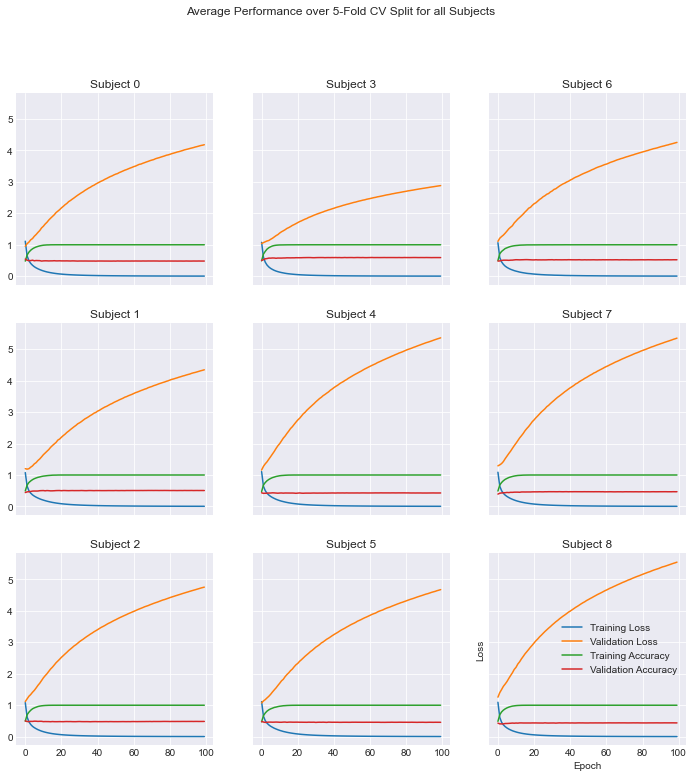

In [8]:
# PLOT MODEL PERFORMANCE DURING TRAINING FOR ALL SUBJECTS
super_average = []

fig,ax = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)

for i,subject in enumerate(subjects):
  s = i
  j = int(i/3)
  i %= 3
  
  fn_filter = f"{subject}"
  performances = [pd.read_csv(f"csv_logs/{fn}",sep=";") for fn in os.listdir("csv_logs/") if subject in fn]
  average_performance = sum(performances)/len(performances)
  super_average.append(average_performance)

  ax[i,j].plot(average_performance.index,average_performance["loss"],label="Training Loss")
  ax[i,j].plot(average_performance.index,average_performance["val_loss"],label="Validation Loss")
  ax[i,j].plot(average_performance.index,average_performance["accuracy"],label="Training Accuracy")
  ax[i,j].plot(average_performance.index,average_performance["val_accuracy"],label="Validation Accuracy")
  ax[i,j].set_title(f"Subject {s}")


fig.suptitle(f"Average Performance over 5-Fold CV Split for all Subjects")
ax[i,j].set_ylabel("Loss")
ax[i,j].set_xlabel("Epoch")
ax[i,j].legend()

plt.show()

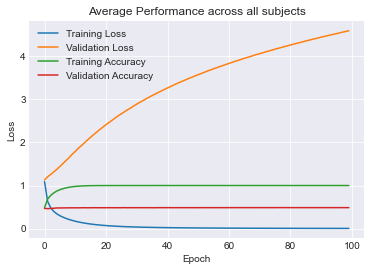

In [9]:
super_average_p = sum(super_average)/len(super_average)
fig,ax = plt.subplots()
ax.plot(super_average_p.index,super_average_p["loss"],label="Training Loss")
ax.plot(super_average_p.index,super_average_p["val_loss"],label="Validation Loss")
ax.plot(super_average_p.index,super_average_p["accuracy"],label="Training Accuracy")
ax.plot(super_average_p.index,super_average_p["val_accuracy"],label="Validation Accuracy")
ax.set_title(f"Average Performance across all subjects")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

In [12]:
performances = [pd.read_csv(f"csv_logs/{fn}",sep=";") for fn in os.listdir("csv_logs/") if "ALL" in fn]
performance_ALL = performances[0]

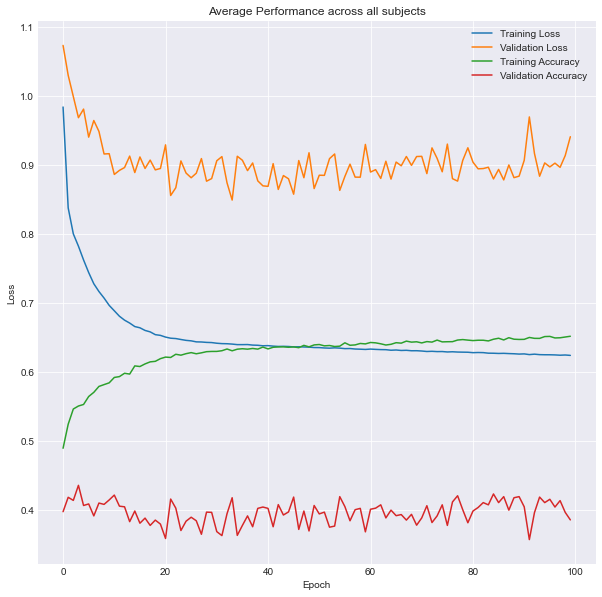

In [18]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(performance_ALL.index,performance_ALL["loss"],label="Training Loss")
ax.plot(performance_ALL.index,performance_ALL["val_loss"],label="Validation Loss")
ax.plot(performance_ALL.index,performance_ALL["accuracy"],label="Training Accuracy")
ax.plot(performance_ALL.index,performance_ALL["val_accuracy"],label="Validation Accuracy")
ax.set_title(f"Average Performance across all subjects")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

# Training a model on all subject data at once.